In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/csc2516_proj')
!pwd

/content/drive/MyDrive/csc2516_proj


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from dataloaders import mias_dataset
from model import cnn_autoencoder

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class mias_dataset(Dataset):
    """
    Dataset class for MIAS (mammogram) data
    """
    def __init__(self, clean_mias_data, noisy_mias_data):
        """
        Args:
            clean_mias_data: ground truth mammograms
            noisy_mias_data: noisy mammograms
        """
        self.clean_data = torch.clone(clean_mias_data)
        self.noise_data = torch.clone(noisy_mias_data)

    def __len__(self):
        return len(self.clean_data)
    
    def __getitem__(self, index):
        return self.clean_data[index], self.noise_data[index]

In [7]:
mias_train_gt = torch.load("mias_train_gt.pt")
mias_train_noisy = torch.load("mias_train_noisy.pt")
mias_dataset_ = mias_dataset(mias_train_gt, mias_train_noisy)
mias_data_loader = DataLoader(dataset=mias_dataset_, batch_size=16, shuffle=True) 

## Visualize training dataset

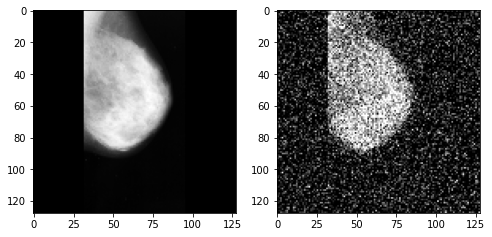

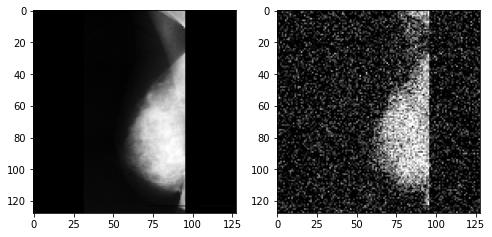

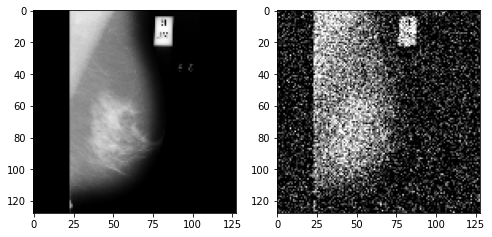

In [8]:
batch = next(iter(mias_data_loader))

for i in range(3): # plot 3 sample data
  clean_img = batch[0][i]
  noisy_img = batch[1][i]
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,16))
  ax1.imshow(clean_img.squeeze(), cmap='gray')
  ax2.imshow(noisy_img.squeeze(), cmap='gray')
  plt.show()


In [9]:
mias_test_gt = torch.load('mias_test_gt.pt').float().to(device)
mias_test_noisy = torch.load('mias_test_noisy.pt').float().to(device)

## Visualize test set

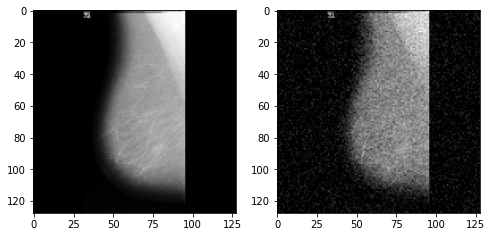

In [10]:
example_gt_test = mias_test_gt[0].cpu()
example_noisy_test = mias_test_noisy[0].cpu()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,16))
ax1.imshow(example_gt_test.squeeze(),cmap='gray')
ax2.imshow(example_noisy_test.squeeze(), cmap='gray')
plt.show()

In [11]:
mias_net = cnn_autoencoder()
mias_net.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mias_net.parameters(), lr=0.001)
mias_net.train()

cnn_autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [12]:
for epoch in range(1000):
    
    running_train_loss = 0
    counter = 0
    for gt, noisy in mias_data_loader:
        
        gt = gt.to(device)
        noisy = noisy.to(device)
        
        optimizer.zero_grad()
        output = mias_net(noisy.float())
        train_loss = criterion(output, gt.float())
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()
        counter += 1
    
    if (epoch+1) % 10 == 0:
        mias_net.eval()
        test_output = mias_net(mias_test_noisy)
        test_loss = criterion(test_output, mias_test_gt)
        test_loss = test_loss.item()
        mias_net.train()
        print("Epoch: {:d}, train loss: {:f}, test loss {:f}".format(epoch, running_train_loss/counter, test_loss))

Epoch: 9, train loss: 0.252596, test loss 0.266549
Epoch: 19, train loss: 0.251323, test loss 0.262503
Epoch: 29, train loss: 0.250650, test loss 0.262012
Epoch: 39, train loss: 0.250051, test loss 0.262085
Epoch: 49, train loss: 0.250075, test loss 0.261778
Epoch: 59, train loss: 0.249829, test loss 0.261849
Epoch: 69, train loss: 0.249779, test loss 0.261800
Epoch: 79, train loss: 0.249635, test loss 0.262975
Epoch: 89, train loss: 0.249327, test loss 0.261659
Epoch: 99, train loss: 0.249203, test loss 0.261683
Epoch: 109, train loss: 0.249313, test loss 0.263442
Epoch: 119, train loss: 0.249060, test loss 0.262174
Epoch: 129, train loss: 0.248864, test loss 0.261648
Epoch: 139, train loss: 0.248885, test loss 0.261504
Epoch: 149, train loss: 0.248825, test loss 0.261718
Epoch: 159, train loss: 0.248680, test loss 0.261765
Epoch: 169, train loss: 0.248618, test loss 0.261679
Epoch: 179, train loss: 0.248680, test loss 0.261607
Epoch: 189, train loss: 0.248602, test loss 0.261583
Epoc

In [13]:
test_pred = mias_net(mias_test_noisy)

for i in range(len(mias_test_noisy)):
  test_img = mias_test_noisy[i].squeeze().cpu().numpy()
  test_pred_img = test_pred[i].squeeze().cpu().detach().numpy()
  gt_img = mias_test_gt[i].squeeze().cpu().numpy()

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,30))
  ax1.imshow(test_img, cmap='gray')
  ax1.set_title("noisy img")
  ax2.imshow(test_pred_img, cmap='gray')
  ax2.set_title("denoised img")
  ax3.imshow(gt_img, cmap='gray')
  ax3.set_title("ground truth")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [14]:
def psnr(clean_imgs, noisy_imgs):
    clean_imgs = clean_imgs.squeeze()
    noisy_imgs = noisy_imgs.squeeze()
    
    # mean over height and width (image)
    mse = torch.mean( (clean_imgs - noisy_imgs) ** 2 , (-2,-1))
    
    # max over height and width (image)
    maxf = torch.max(clean_imgs, -1)
    maxf = torch.max(maxf.values, -1)
    
    # mean psnr over batch
    psnr = torch.mean(20 * torch.log10(torch.divide(maxf.values, torch.sqrt(mse))))
    return psnr

In [15]:
mean_psnr = psnr(mias_test_gt, test_pred)
print(mean_psnr)

tensor(31.6374, device='cuda:0', grad_fn=<MeanBackward0>)


In [16]:
import cv2 as cv

In [37]:
noisy_img = mias_test_noisy[2]
noisy_img = (noisy_img.cpu().numpy().squeeze() * 255).astype(np.uint8)
denoised = cv.fastNlMeansDenoising(noisy_img, None, 50, 7, 21)

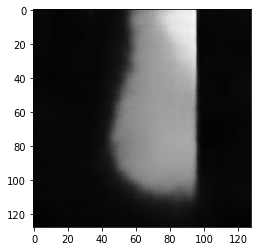

In [38]:
plt.imshow(denoised, cmap='gray')
plt.show()